## **Understanding Semantic Kernel**

Before diving into the implementation, let's understand the key components of Semantic Kernel.

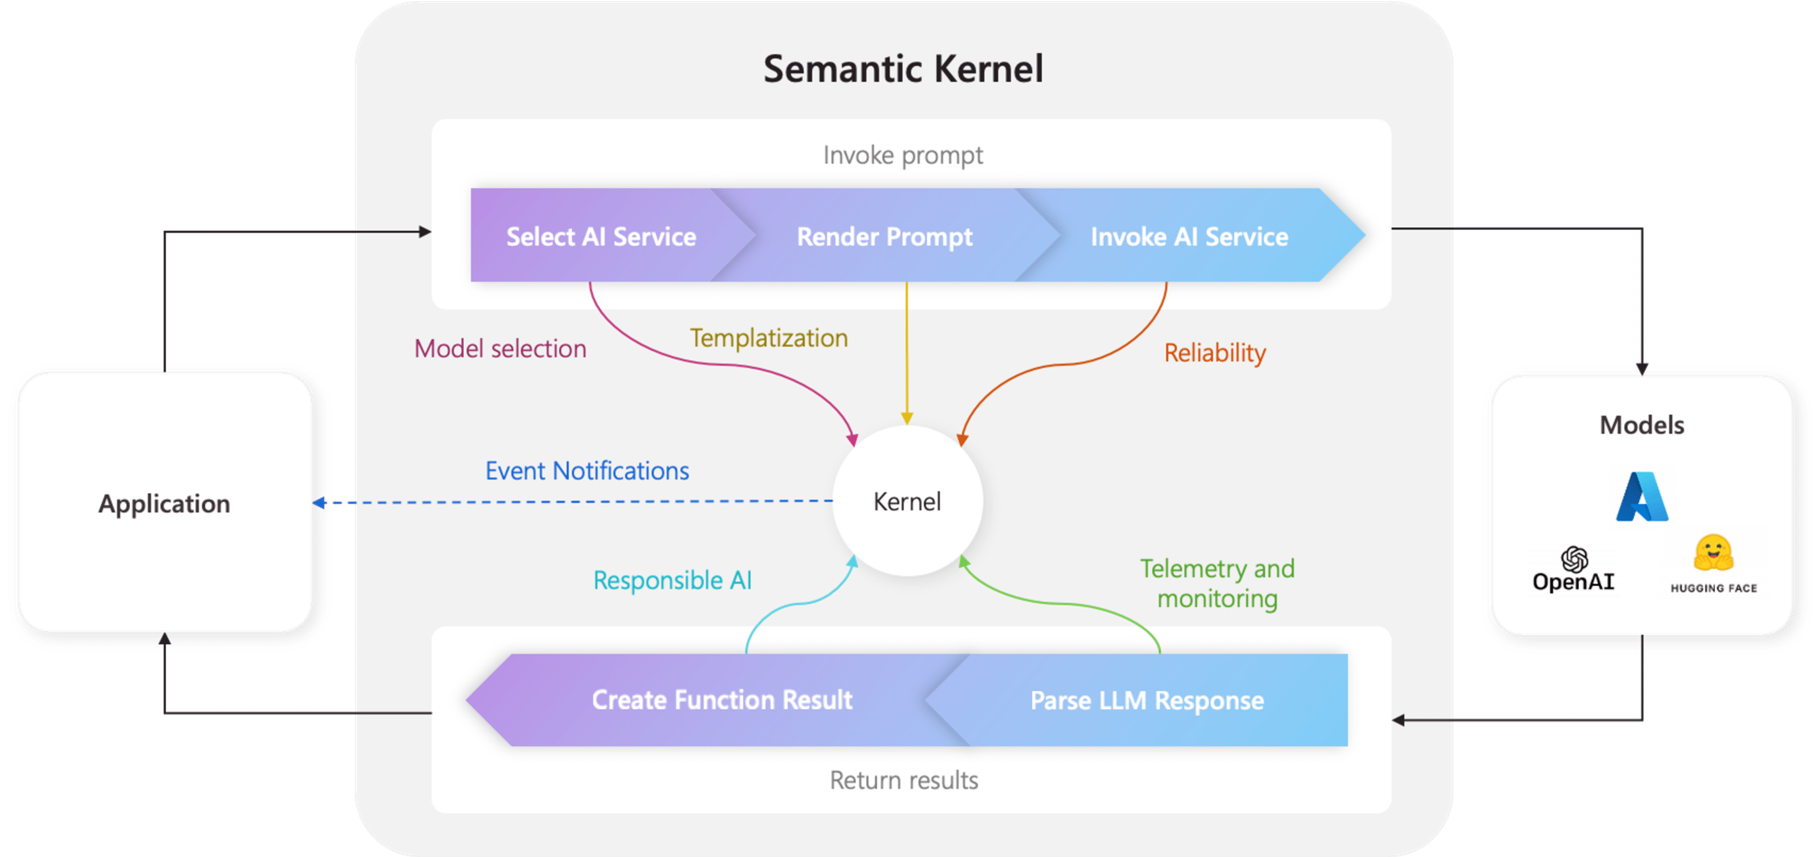

#### **The Kernel**

The Kernel is the central orchestrator in Semantic Kernel. It manages:

- **Connecting to AI Models**: Interfaces with various AI models via connectors.
+ **Registering and Invoking Plugins**: Manages the lifecycle and execution of plugins.
- **Managing Memory and Context**: Maintains state and context across interactions.
+ **Interacting with the Planner**: Coordinates with the Planner to achieve specified goals.

#### **Connectors**

Connectors allow the Kernel to interface with various AI models and services. They define how the Kernel communicates with these models, whether they're:

- **OpenAI Models**: Such as GPT-3.5, GPT-4.
+ **Azure OpenAI Services**: Leveraging Microsoft's cloud-based AI capabilities.
- **Local Models**: Using libraries like Hugging Face Transformers.

#### **Plugins**

Plugins are modular units that extend the Kernel's functionality. They consist of:

- **Prompt Functions**: Use natural language prompts to interact with AI models.
+ **Native Functions**: Written in Python, performing deterministic tasks or interfacing with external services.

Plugins act as building blocks for complex workflows.

#### **The Planner**

The Planner uses AI to dynamically create a sequence of actions (a plan) to achieve a specified goal. It considers:

- **Available Plugins and Their Functions**: Understands the capabilities of each plugin.
+ **Function Descriptions**: Uses metadata to understand what each function does.
- **Combining Functions**: Determines how functions can be combined to fulfill the goal.


## **Scenario: Building Smart Entity and Intent Recognition**

 This guide illustrates a robust system with two key skills: **Intent Classification** and **Named Entity Recognition (NER)**. The architecture involves:

### **Key Skills (plugins)**

1. **Intent Classification**: Determines the purpose of the user’s query, leveraging LLMs.
2. **Entity Recognition**: Extracts entities like names, dates, or medical terms, using advanced Named Entity Recognition (NER) capabilities also laveraging LLMs.

By leveraging Semantic Kernel's capabilities, we can create a robust system that avoids single points of failure by running in parallel and utilizing multiple skills. Let's dive in!

### **Implementation**

We will:

1. **Define Plugins**: Create plugins for the Medical Researcher, Clinical Evaluator, and Medical Editor.
2. **Configure the Kernel**: Set up the Kernel with the necessary connectors and plugins.
3. **Develop the Planner**: Implement the Planner to dynamically orchestrate the workflow.
4. **Execute the Plan**: Run the system to produce high-quality medical documentation.

In [1]:
import os
import pprint

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab


In [2]:
#!pip install semantic-kernel --upgrade
import semantic_kernel as sk

print(f"We are using the following semantic_kernel library version: {sk.__version__}")

We are using the following semantic_kernel library version: 1.20.0


**1. Define Plugins**

We have defined the plugin for MedicalAgents located in the specified directory  `C:\Users\pablosal\Desktop\gbbai-agent-architecture-lab\src\plugins\plugins_store`

**2. Configure The Kernel**

In [3]:
import semantic_kernel as sk

# Initialize the kernel
kernel = sk.Kernel()

In [4]:
# add Azure OpenAI service connector to the kernel
import os
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

# Load environment variables from a .env file
from dotenv import load_dotenv

load_dotenv()

AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_API_ENDPOINT = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
AZURE_OPENAI_EMBEDDING_DEPLOYMENT = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT")
AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID = os.getenv(
    "AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"
)

service_id = "openai-chat"
# Add Azure OpenAI chat completion
kernel.add_service(
    AzureChatCompletion(
        service_id=service_id,
        deployment_name=AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID,
        api_key=AZURE_OPENAI_KEY,
        endpoint=AZURE_OPENAI_API_ENDPOINT,
        api_version=AZURE_OPENAI_API_VERSION,
    )
)

In [5]:
print("Registered services:", kernel.services)

Registered services: {'openai-chat': AzureChatCompletion(ai_model_id='gpt-4o', service_id='openai-chat', instruction_role='system', client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000021EA4D18070>, ai_model_type=<OpenAIModelTypes.CHAT: 'chat'>, prompt_tokens=0, completion_tokens=0, total_tokens=0)}


In [6]:
# Define the parent directory and plugin name
parent_directory = os.path.abspath(os.path.join("src", "plugins"))
plugin_name = "plugins_store"

# Add the plugin to the kernel
plugin = kernel.add_plugin(parent_directory=parent_directory, plugin_name=plugin_name)

print("Available functions in intentPlugin plugin:")

print("Loaded plugin functions:", plugin.functions.keys())

print(plugin.functions["intentPlugin"].metadata)

Available functions in intentPlugin plugin:
Loaded plugin functions: dict_keys(['intentPlugin', 'nerPlugin'])
name='intentPlugin' plugin_name='plugins_store' description='Classify a sports-related user query into one of the predefined intent categories (e.g., summarize, historical, scores, etc.)' parameters=[KernelParameterMetadata(name='input', description='The user’s sports-related query or statement to be classified', default_value='', type_='', is_required=True, type_object=None, schema_data={'type': 'object', 'description': 'The user’s sports-related query or statement to be classified'}, include_in_function_choices=True)] is_prompt=True is_asynchronous=True return_parameter=KernelParameterMetadata(name='return', description='The completion result', default_value=None, type_='FunctionResult', is_required=True, type_object=None, schema_data=None, include_in_function_choices=True) additional_properties=None


In [7]:
from semantic_kernel.functions.kernel_arguments import KernelArguments

arguments = KernelArguments(
    input="I just need a high-level recap of the Warriors’ playoff performance."
)
print("Arguments:", arguments)

result = await kernel.invoke(
    plugin.functions["intentPlugin"], arguments, service_id="openai-chat"
)
print("Result:", result)

Arguments: {'input': 'I just need a high-level recap of the Warriors’ playoff performance.'}


Result: ```json
{ "intent": "summarize" }
```


In [8]:
from semantic_kernel.functions.kernel_arguments import KernelArguments

arguments = KernelArguments(
    input="I just need a high-level recap of the Warriors’ playoff performance."
)
print("Arguments:", arguments)

result = await kernel.invoke(
    plugin.functions["nerPlugin"], arguments, service_id="openai-chat"
)
print("Result:", result)

Arguments: {'input': 'I just need a high-level recap of the Warriors’ playoff performance.'}
Result: ```json
{
  "entities": [
    { "text": "Warriors", "category": "Organization" }
  ]
}
```


**3. Develop the Planer**

In [9]:
from semantic_kernel.connectors.ai.chat_completion_client_base import (
    ChatCompletionClientBase,
)
from semantic_kernel.connectors.ai.open_ai.prompt_execution_settings.azure_chat_prompt_execution_settings import (
    AzureChatPromptExecutionSettings,
)
from semantic_kernel.connectors.ai.function_choice_behavior import (
    FunctionChoiceBehavior,
)

chat_completion: AzureChatCompletion = kernel.get_service(type=ChatCompletionClientBase)
execution_settings = AzureChatPromptExecutionSettings()
execution_settings.function_choice_behavior = (
    FunctionChoiceBehavior.Auto()
)  # the automatic planning loop https://learn.microsoft.com/en-us/semantic-kernel/concepts/planning?pivots=programming-language-python#the-automatic-planning-loop

**4. Execute the Plan**

In [10]:
from semantic_kernel.functions.kernel_arguments import KernelArguments
from semantic_kernel.contents.chat_history import ChatHistory
import logging
from semantic_kernel.utils.logging import setup_logging
import asyncio  # Required to run async functions

# Create a history of the conversation
chat_history = ChatHistory()

# Add system message to define the system's role
chat_history.add_system_message(
    """You are an AI-powered assistant specializing in Named Entity Recognition (NER) and Intent Classification. 
    Your goal is to analyze user input, extract named entities, classify the user's intent, and return results in a structured JSON format. 
    The JSON should include the following fields:
    1. 'entities': A list of named entities found in the user input, each with 'text' and 'category' fields.
    2. 'intent': The classified intent of the user input.
    
    Here are some examples of the expected JSON output format:
    
    Example 1:
    {
        "entities": [
            { "text": "LeBron James", "category": "Person" },
            { "text": "50", "category": "Quantity" },
            { "text": "yesterday", "category": "DateTime" },
            { "text": "Warriors", "category": "Organization" }
        ],
        "intent": "scores"
    }
    
    Example 2:
    {
        "entities": [
            { "text": "Paris", "category": "Location" },
            { "text": "Eiffel Tower", "category": "Location" },
            { "text": "next week", "category": "DateTime" }
        ],
        "intent": "schedule"
    }
    
    Example 3:
    {
        "entities": [
            { "text": "Apple", "category": "Organization" },
            { "text": "iPhone 15", "category": "Product" },
            { "text": "release date", "category": "DateTime" }
        ],
        "intent": "None"
    }
    """
)

# Add user message to the chat history
user_input = "I just need a high-level recap of the Warriors’ playoff performance."
chat_history.add_user_message(user_input)

# Set up logging
logging.basicConfig(
    format="[%(asctime)s - %(name)s:%(lineno)d - %(levelname)s] %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
setup_logging()
logging.getLogger("kernel").setLevel(logging.INFO)


async def get_ai_response():
    if chat_completion is None or execution_settings is None or kernel is None:
        raise ValueError(
            "chat_completion, execution_settings, and kernel must be initialized."
        )

    result = (
        await chat_completion.get_chat_message_contents(
            chat_history=chat_history,
            settings=execution_settings,
            kernel=kernel,
        )
    )[0]

    print("AI Response:", result)


await get_ai_response()

AI Response: ```json
{
    "entities": [
        { "text": "Warriors", "category": "Organization" }
    ],
    "intent": "summarize"
}
```


**5. (Bonus) Understand Memory components**

**Memory as a Vector Store**
Semantic Kernel allows you to implement memory by using vector stores as persistent repositories for storing semantic information. When you add a document (or “record”)—for example, a PolicyRecord—to a vector store (such as Azure AI Search), it is saved along with its high-dimensional vector representation (embedding) that captures its core semantic meaning. This mechanism mirrors how human memory often retains the “gist” of an experience rather than every specific detail.

**Storing Semantic Information**

To store data, Semantic Kernel first converts text into an embedding using an embedding generation service (like OpenAITextEmbeddingGeneration). This service transforms raw text into a numerical vector that encodes its meaning, and the resulting embedding is then stored in a memory store (which might be persistent, such as Azure AI Search, or transient, like a VolatileMemoryStore). In effect, both the original text and its semantic signature are preserved, enabling nuanced understanding and later retrieval.

**Retrieving with Vector Search**

When a query is made—for example, “What is the policy for diabetes?”—Semantic Kernel generates an embedding for the query and uses vector search to compare it against stored embeddings. By calculating similarity metrics such as cosine similarity, the system efficiently retrieves records that are semantically close to the query, effectively “recalling” memory that is contextually relevant.

*Here is the schema of my AzureAISearch (I used integrated vectorization while indexing) for this example*

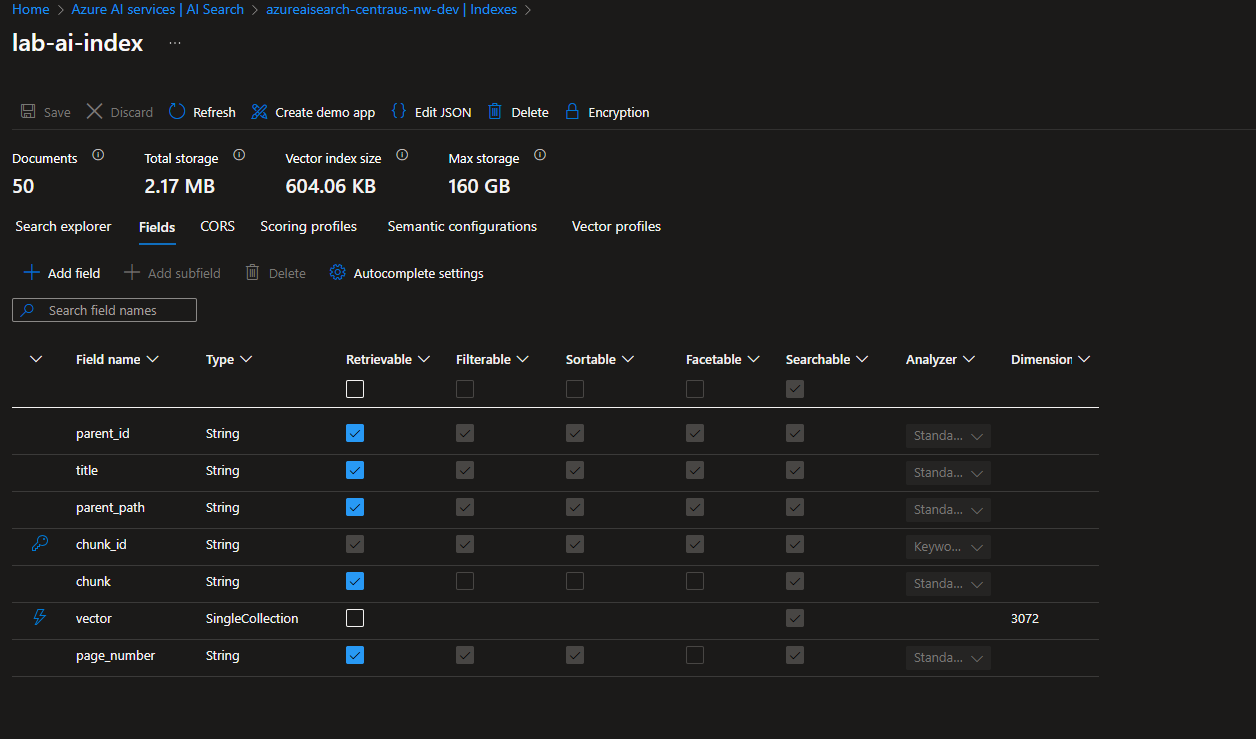

In [11]:
import os
from dotenv import load_dotenv
from src.aoai.azure_openai import AzureOpenAIManager

# Load environment variables from .env file
load_dotenv()

aoai_client = AzureOpenAIManager(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_API_ENDPOINT"),
    chat_model_name=os.getenv("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID"),
    embedding_model_name=os.getenv("AZURE_AOAI_EMBEDDINGS_MODEL_NAME_DEPLOYMENT_ID"),
)

In [12]:
# Define query text.
query_text = "What is the policy for diabetes?"
embedding_vector = aoai_client.generate_embedding(query_text)

In [ ]:
from dataclasses import dataclass, field
from typing import List, Optional
from semantic_kernel.data import (
    VectorStoreRecordDefinition,
    VectorStoreRecordKeyField,
    VectorStoreRecordDataField,
    VectorStoreRecordVectorField,
)


@dataclass
class PolicyRecord:
    parent_id: str
    title: str
    parent_path: str
    chunk_id: str  # We'll treat this field as the unique key.
    chunk: str
    page_number: str
    vector: Optional[List[float]] = field(
        default=None
    )  # Set a default value so it's optional.


# Create a record definition for your index schema.
policy_definition = VectorStoreRecordDefinition(
    fields={
        "chunk_id": VectorStoreRecordKeyField(property_type="str"),
        "parent_id": VectorStoreRecordDataField(
            property_type="str", is_filterable=True
        ),
        "title": VectorStoreRecordDataField(
            property_type="str", is_full_text_searchable=True
        ),
        "parent_path": VectorStoreRecordDataField(property_type="str"),
        "chunk": VectorStoreRecordDataField(
            property_type="str", is_full_text_searchable=True
        ),
        # For the vector field, specify its type as a collection of floats and its dimensions.
        "vector": VectorStoreRecordVectorField(property_type="float", dimensions=3072),
        "page_number": VectorStoreRecordDataField(property_type="str"),
    },
    container_mode=False,
)

import os
from semantic_kernel.connectors.memory.azure_ai_search import AzureAISearchStore
from semantic_kernel.data.vector_search import VectorSearchOptions

# Initialize the vector store using environment variables.
vector_store = AzureAISearchStore(
    search_endpoint=os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT"),
    api_key=os.getenv("AZURE_AI_SEARCH_ADMIN_KEY"),
)


# Adding (Injecting) Data into Memory:
# Although this code sample focuses on searching the collection,
# before you can search (or “recall” memory), you would typically add your records
# (e.g., instances of PolicyRecord) to this collection. This is often done via an upload or
# add method (for example, collection.upload_documents(records) or a similar method, depending on the connector).
# Once the records are added, they become part of the persistent “memory.”
# Get your collection (which wraps your index "ai-policies-index").
collection = vector_store.get_collection(
    collection_name="ai-policies-index",
    data_model_type=PolicyRecord,
    data_model_definition=policy_definition,
)

# Generate the embedding vector for your query.
embedding_response = aoai_client.generate_embedding(query_text)
embedding_vector = embedding_response.data[0].embedding

# Set up search options to target the "vector" field.
options = VectorSearchOptions(
    vector_field_name="vector",  # Name of the vector field in your model
    top=10,
    min_relevance=0.3,
)

# Perform the asynchronous vectorized search by passing the embedding vector directly.
search_result = await collection.vectorized_search(
    vector=embedding_vector, options=options
)

# Iterate asynchronously over the results.
async for result in search_result.results:
    print("Found document:", result.record.title)
    print("Content:", result.record.chunk)